# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек и глобальные установки

In [1]:
import math
import nltk
import numpy as np
import pandas as pd
import warnings
import collections
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import re

from pymystem3 import Mystem

from nltk import WordNetLemmatizer
from nltk.corpus import (
    wordnet,
    stopwords as nltk_stopwords,
)

from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer #, CountVectorizer
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

color_end = color.END
red_start = color.RED
blue_start = color.BLUE
purple_start = color.PURPLE

RANDOM_STATE = 2025

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

### Загрузка наборов данных

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lopat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\lopat\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lopat\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lopat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Функции

#### **`column_analiser`** - анализ числовых признаков

In [5]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    print_unique = False,
    bins_= 70,
    figsize_ = (15, 10),
    height_ratios_ = [1, 3],
    hue_lst_ = [],
    kde_plot_log_flag_ = False,
    kde_plot_figsize_ = (15, 10),
    kde_plot_title = '',
    kde_plot_x_label = '',
    kde_plot_y_label = ''
):

    record_count = df_.shape[0]
    
    print('_____________________________________________________________________________________________________________________________')
    print(' ')
    print(blue_start, f'Поле : {column_} - {x_label}', color_end)
    isna_count = df_[column_].isna().sum()
    print(blue_start, '    Количество пропусков - ', color_end, isna_count)
    print(blue_start, '    Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), '%')
    print('')
    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
        
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = figsize_, gridspec_kw={'height_ratios': height_ratios_})
        
    if kde_plot_log_flag_:
        axes[0] = np.log1p(df_[column_]).plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            np.log1p(df_[column_]),
            bins=bins_
        )
    else:
        axes[0] = df_[column_].plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            df_[column_],
            bins=bins_,
        )

    axes[0].set_ylabel(y_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Распределение')    
    plt.show()    
    
    if len(hue_lst_) > 0:
        for hue_ in hue_lst_:
            if kde_plot_log_flag_:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = np.log1p(df_[column_]),
                            hue = hue_,
                            fill = True)
            else:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = df_[column_],
                            hue = hue_,
                            fill = True)
                
            plt.title(kde_plot_title)
            plt.xlabel(kde_plot_x_label)
            plt.ylabel(kde_plot_y_label)
            plt.show()

#### **`get_dictionary`** - Формирование словаря по корпусу

In [6]:
def get_dictionary(
    corpus,
    words_count = 30,
    font_size = 12,
    fig_size = (12, 8),
    title_ = ''):
    
    
    tokens = ' '.join(corpus).split()
    
    dictionary = collections.Counter(tokens)
    
    dictionary_df = pd.DataFrame(
        dictionary.most_common(),
        columns = ['word', 'count'])

   
    return dictionary_df

#### **`get_dictionary`** - Визуализация словаря

In [7]:
def dictionary_visualization(
    dictionary_df,
    words_count = 30,
    font_size = 12,
    fig_size = (12, 8),
    title_ = ''):

    print(blue_start, 'Количество слов в словаре - ',color_end, len(dictionary_df))

    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = fig_size)
    
    dictionary_df.head(words_count).sort_values(by = 'count').plot.barh(
        x = 'word',
        y = 'count',
        ax = ax,
        color = 'purple'
    )

    if title_ == '':
        ax.set_title(str(words_count) + ' самых встречающиеся слов.', fontsize = font_size + 4)
    else:
        ax.set_title(title_)
    
    ax.set_xlabel('Количество ', fontsize = font_size)
    ax.set_ylabel('Слова', fontsize = font_size)

#    plt.grid()
    plt.show()


#### **`clear_text`** - Очистка текста

In [8]:
def clear_text(text, stop_words):
# перевод text в нижний регистр
    text = text.lower()
# формирование списка слов
    text_lst = text.split()
# очистка списка от stop_words
    text_lst = [word for word in text_lst if word not in stop_words]

# Так может быть быстрее, но нарушается порядок слов в text_lst   
#    text_lst = list(set(text_lst) - set(stop_words))

# Формирование текста по очищенному списку
    text = ' '.join(text_lst)
# Формирование текста, очищенного от ненужных символов
    return ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split())

#### **`pos_tagger`** - формирование POS-тагов

In [9]:
# https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/
# Расшифровка POS-тегов
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

#### **`lemmatize_text`** - Лемматизация

In [10]:
# https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/
def lemmatize_text(lemmatizer, text):
#    text = 'the cat is sitting with the bats on the striped mat under many badly flying geese'
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
#    print(pos_tagged)
#    print('')
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
#    print(wordnet_tagged)
    
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:        
            # else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    lemmatized_text = ' '.join(lemmatized_text)
     
    return lemmatized_text

#### **`load_date`** - загрузка файлов

In [11]:
# Функция загрузки file_name_ с возможностью парсинга даты (парсить/не парсить) 
# и отображением первых file_name_ строк
# последовательность попыток загрузки по локациям:
#    - текущая (локальная) директория 
#    - директория тренажера
#    - https://code.s3.yandex.net/datasets/

def load_date(
    file_name_,
    parse_dates_,
    head_rows_ = 1):
    
    read_csv_res = red_start + 'ОШИБКА - ' + file_name_ + '- не загружен' + color_end
    err = False
    try:
        df_ = pd.read_csv(
            file_name_,
            parse_dates = parse_dates_
        )
        read_csv_res = blue_start + file_name_ + ' загружен из локальной директории' + color_end
    except:
        try:
            file_path = '/datasets/'
            df_ = pd.read_csv(
                file_path + file_name_,
                parse_dates = parse_dates_
            )
            read_csv_res = blue_start + file_name_ + ' загружен в тренажере' + color_end
        except:
            try:
                file_path = 'https://code.s3.yandex.net/datasets/'
                df_ = pd.read_csv(
                    file_path + file_name_,
                    parse_dates = parse_dates_
                )
                read_csv_res = blue_start + file_name_ + ' загружен из - ' + file_path + color_end
            except:
                read_csv_res = red_start + 'ОШИБКА - '  + file_name_ + ' - не загружен' + color_end
                err = True
    print(read_csv_res)
    if err:
        return 'ОШИБКА ЧТЕНИЯ'
    else:
        df_.name = file_name_
        display(df_.head(head_rows_))
        return df_

#### **`categorical_property_visualization`** - визуализация категориальных признаков

In [12]:
def categorical_property_visualization(
    data_,
    indexes_=[],
    titles_=[],
    values_='',
    aggfunc_='count',
#    nrows_= 2,
    ncols_= 3,
    figsize_=(20, 7),
    title_ = '',
    y_title_ = 1,
    title_under_line_flag_ = True,
    title_fontsize_ = 15
):

    nrows_ = math.ceil(len(indexes_) / ncols_)
    
    columns = data_.columns
    record_count = data_.shape[0]
    
    row_ind = 0
    col_ind = 0
    subplot_ind = 0
    
    if nrows_ * ncols_ < len(indexes_):
        print('Несоответствие - nrows_ * ncols_ < ', len(indexes_))
        return

    fig, axes = plt.subplots(nrows = nrows_, ncols = ncols_, figsize = figsize_)
    if title_under_line_flag_:
        title_ = title_ + '\n' + ('_' * (len(title_)  + 6))
    fig.suptitle(title_, fontsize = title_fontsize_, y = y_title_)

    for x in axes.ravel():
        x.axis("off")    
        #print(row_ind, col_ind)
        #print(len(axes.shape))

    for ind in indexes_:
        if len(axes.shape) == 1:
            current_ax = axes[subplot_ind]
        else:
            current_ax = axes[row_ind, col_ind]
        
        for_plot_df = data_.pivot_table(
                index=ind,
                values=values_,
                aggfunc=aggfunc_
            )
        for_plot_df.columns = ['count']
        for_plot_df.plot(
                kind='pie',
                ax = current_ax,
                #y='id',
                y='count',
#                autopct='%1.0f%%'
                autopct='%.2f%%'
            )

        current_ax.set_title(titles_[subplot_ind])
        current_ax.get_legend().remove()
            
        subplot_ind += 1
        col_ind += 1
        if col_ind == ncols_: #3
            col_ind = 0
            row_ind += 1

#### **`df_inf`** - информация о дата фрейме

In [13]:
def df_inf(df, head_row = 5, drop_duplicates_flag=False):
    print(purple_start, '_________________________________________________________________________________', color_end)
 
    try:
        df_name = df.name
        print(blue_start,'Имя:', df_name, color_end)
    except:
        df_name = 'Не определено'
        print(blue_start,'Имя: Не определено', color_end)
    print('')
    
    df_shape_ = df.shape
    
    print(blue_start, df_name, '(первые', head_row, 'строк)', color_end)
    display(df.head(head_row))
    print('')
    
    print(blue_start,'Информация: ', color_end)
    df.info()
    print('')

    try:
        print(blue_start,'Описание числовых полей: ', color_end)
        display(df.describe(exclude=['O']))
    except ValueError:
        print(blue_start,'Числовых полей нет!', color_end)
        
    print('')
    
    try:
        print(blue_start,'Описание не числовых полей: ', color_end)
        display(df.describe(include=['O']))
    except ValueError:
        print(blue_start,'Не числовых полей нет!', color_end)
        
    print('')

    print(blue_start,'Пропуски: ', color_end)
    display(df.isna().sum().T)
    print('')
    
    df_duplicates = []
    df_duplicates = df[df.duplicated()]

    #isna_record_count  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
    record_count = df_shape_[0]
    isna_record_count  = df[df.isnull().any(axis=1)].shape[0]
    
    print(blue_start, 'Доля записей, содержащих пропуски:',color_end, round((isna_record_count/record_count)*100, 2),'%')
    
    if len(df_duplicates) > 0:
        print(' ')
        print(blue_start,'Количество дубликатов:',len(df_duplicates), color_end)
        print(blue_start,'Дубликаты (первые', head_row, 'строк)', color_end)
        display(df_duplicates.head(head_row))
        if drop_duplicates_flag:
            print(blue_start,'Дубликаты удалены!', color_end)
            df.drop_duplicates(keep = 'first', inplace = True)
            df_duplicates = df[df.duplicated()]
            print(blue_start,'Количество дубликатов после удаления:',len(df_duplicates), color_end)
    else:
        print(blue_start,'Дубликаты не обнаружены!', color_end)
    print(' ')
    return df_duplicates, df_shape_

### Загрузка и исследование данных

In [14]:
comments_df = load_date(
    file_name_ = 'toxic_comments.csv',
    parse_dates_ = False,
    head_rows_ = 2)

toxic_comments.csv загружен из локальной директории


,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0


In [15]:
duplicates_df, comments_df__original_shape = df_inf(df = comments_df, head_row = 2, drop_duplicates_flag = False)

 _________________________________________________________________________________ 
 Имя: toxic_comments.csv 

 toxic_comments.csv (первые 2 строк) 


,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

 Описание числовых полей:  


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000



 Описание не числовых полей:  


,text
count,159292
unique,159292
top,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
freq,1



 Пропуски:  


Unnamed: 0    0
text          0
toxic         0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


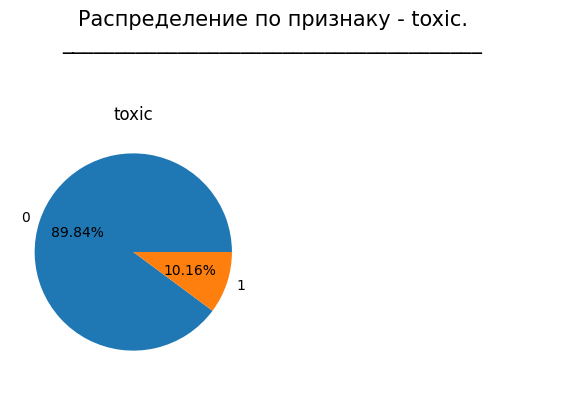

In [16]:
indexes = [
    'toxic'
]

titles = [
    'toxic'
]
categorical_property_visualization(
    data_= comments_df,
    indexes_ = indexes,
    titles_ =  indexes,
    values_ = 'text',
    aggfunc_='count',
    title_ = 'Распределение по признаку - toxic.',
    figsize_=(7, 4),
    ncols_= 2,
    title_under_line_flag_ = True,
    title_fontsize_ = 15,
    y_title_ = 1.1)

In [17]:
# Проверка уникальности значений признака
pd.Series(comments_df['Unnamed: 0']).is_unique

True

#### **`Выводы`**

* Данные загружены (159292 - записи)
* Структура датафрейма (поля):
    * Unnamed: 0 - поле содержит уникальные значения, подходит для переформирования в уникальный индекс
    * text - содержание комментария
    * toxic - целевой бинарный признак (1 - токсичный 10.16% записей, 0 - нетоксичный 89.84% записей)

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные загружены корреткно. Молодец, что проверяешь баланс классов)

### Предобработка данных

In [18]:
# определение имен полей
comments_df.columns = ['text_ind', 'text', 'toxic']
# comments_df['text'] = comments_df['text'].astype('U')

#### Очистка и лемматизация

In [20]:
# Формирование списка английских стоп-слов
stop_words = set(nltk_stopwords.words('english'))

In [21]:
%%time
# Очистка текста от стоп-слов
comments_df['cleared_text'] = comments_df['text'].apply(lambda x: clear_text(x, stop_words))

CPU times: total: 7 s
Wall time: 7.01 s


In [22]:
%%time
lemmatizer = WordNetLemmatizer()
# Лемматизация с POS-тегами
# comments_df['lemm_text'] = comments_df['cleared_text'].apply(lambda x: lemmatize_text(lemmatizer, x))
tqdm.pandas()
comments_df['lemm_text'] = comments_df['cleared_text'].progress_apply(lambda x: lemmatize_text(lemmatizer, x))

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [07:57<00:00, 333.50it/s]

CPU times: total: 7min 55s
Wall time: 7min 57s


In [23]:
# Формирование индекса по полю text_ind
comments_df.set_index('text_ind', inplace = True)

#### **`Выводы`**

* Перечень полей датафрейма:
    * `text_ind` - порядковый номер комментария (по полю 'text_ind' сформирован уникальный индекс)
    * `text` - содержание комментария.
    * `toxic` - целевой бинарный признак (1 - токсичный, 0 - нетоксичный)
* Сформировано поле `cleared_text` - данные `text` переведены в нижний регистр очищены от `stop_words`
* Поле `lemm_text` - содержит лемматизированные слова поля `cleared_text`

### Исследование данных

#### Целевой признак

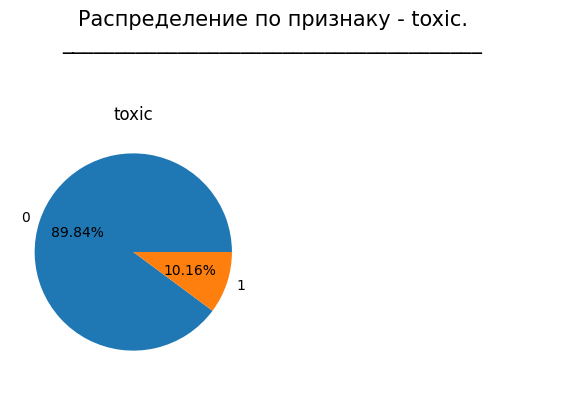

In [24]:
indexes = [
    'toxic'
]

titles = [
    'toxic'
]
categorical_property_visualization(
    data_= comments_df,
    indexes_ = indexes,
    titles_ =  indexes,
    values_ = 'text',
    aggfunc_='count',
    title_ = 'Распределение по признаку - toxic.',
    figsize_=(7, 4),
    ncols_= 2,
    title_under_line_flag_ = True,
    title_fontsize_ = 15,
    y_title_ = 1.1)

#### Формирование дополнительных числовых признаков

In [25]:
# количество лемматизированных слов в сообщении
comments_df['lemm_words_count'] = comments_df['lemm_text'].apply(lambda x: len(x.split()))

# количество уникальных лемматизированных слов в сообщении
comments_df['lemm_unique_words_count'] = comments_df['lemm_text'].apply(lambda x: len(set(x.split())))

# длина лемматизированного сообщения
comments_df['lemm_comments_len'] = comments_df['lemm_text'].apply(lambda x: len(x))

# Количество букв в комментарии
comments_df['lemm_letters_count'] = comments_df['lemm_comments_len'] - comments_df['lemm_text'].str.count(' ')

# отношение количества лемматизированных слов к количеству уникальных лемматизированных слов в сообщении
comments_df['lemm_words_koeff'] = comments_df['lemm_unique_words_count'] / comments_df['lemm_words_count']

# средняя длина лемматизированного слова в сообщении (без учета пробелов) - количество букв / количество слов
comments_df['lemm_words_avg_len'] = comments_df['lemm_letters_count'] / comments_df['lemm_words_count']

#### Визуализация числовых признаков

_____________________________________________________________________________________________________________________________
 
 Поле : lemm_words_count - Количество слов 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    159292.000000
mean         36.915432
std          57.259804
min           0.000000
25%           9.000000
50%          19.000000
75%          40.000000
max        1349.000000
Name: lemm_words_count, dtype: float64


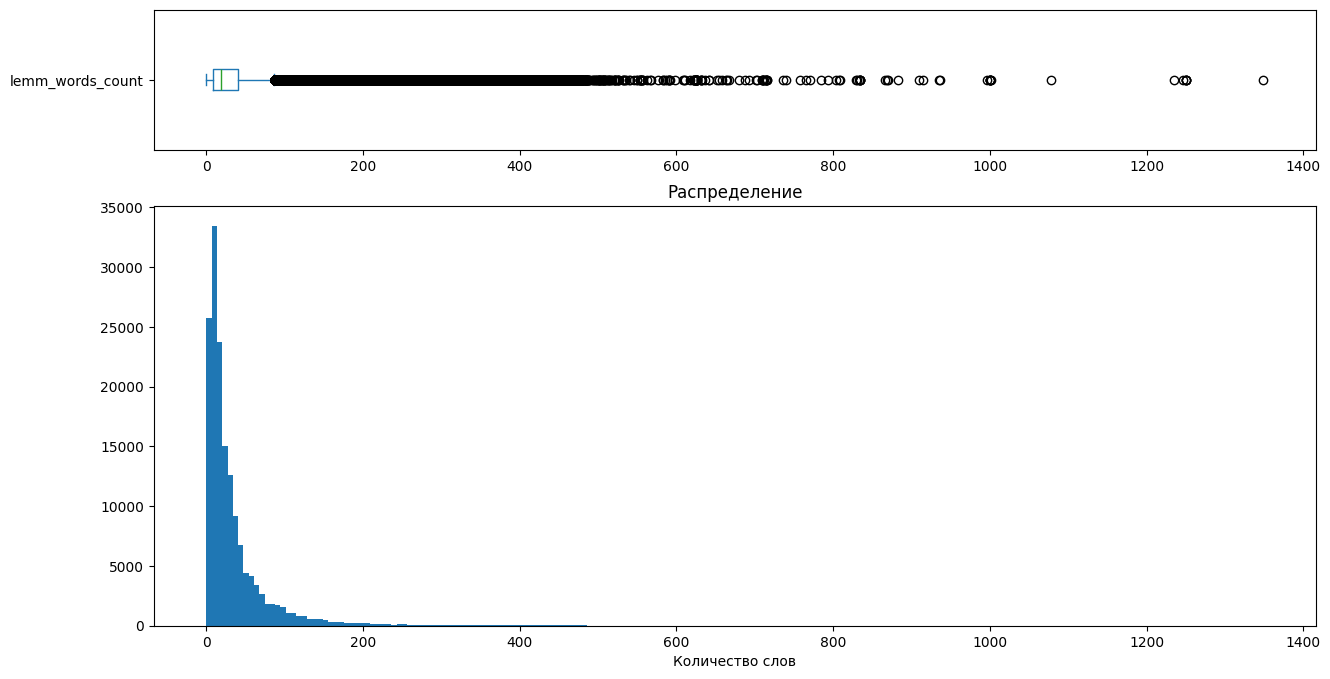

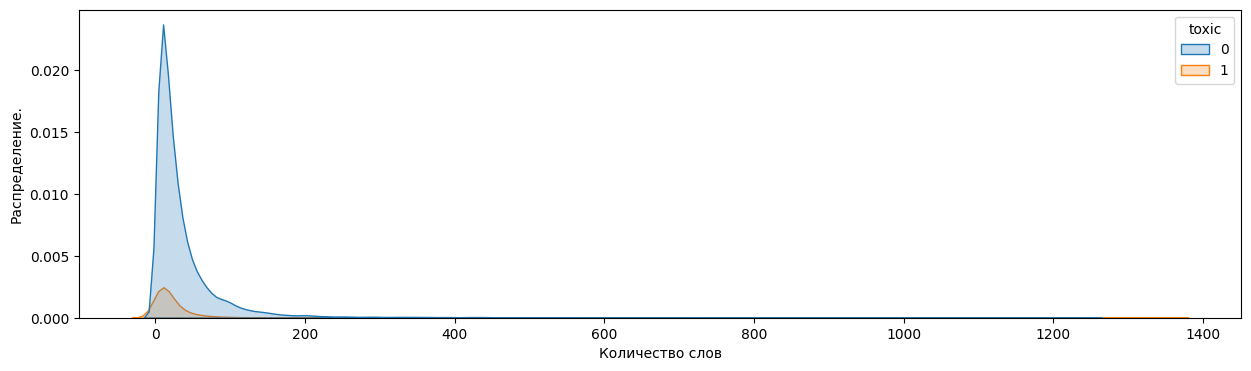

_____________________________________________________________________________________________________________________________
 
 Поле : lemm_unique_words_count - Количество уникальных слов 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    159292.000000
mean         28.355931
std          34.669123
min           0.000000
25%           9.000000
50%          17.000000
75%          34.000000
max         398.000000
Name: lemm_unique_words_count, dtype: float64


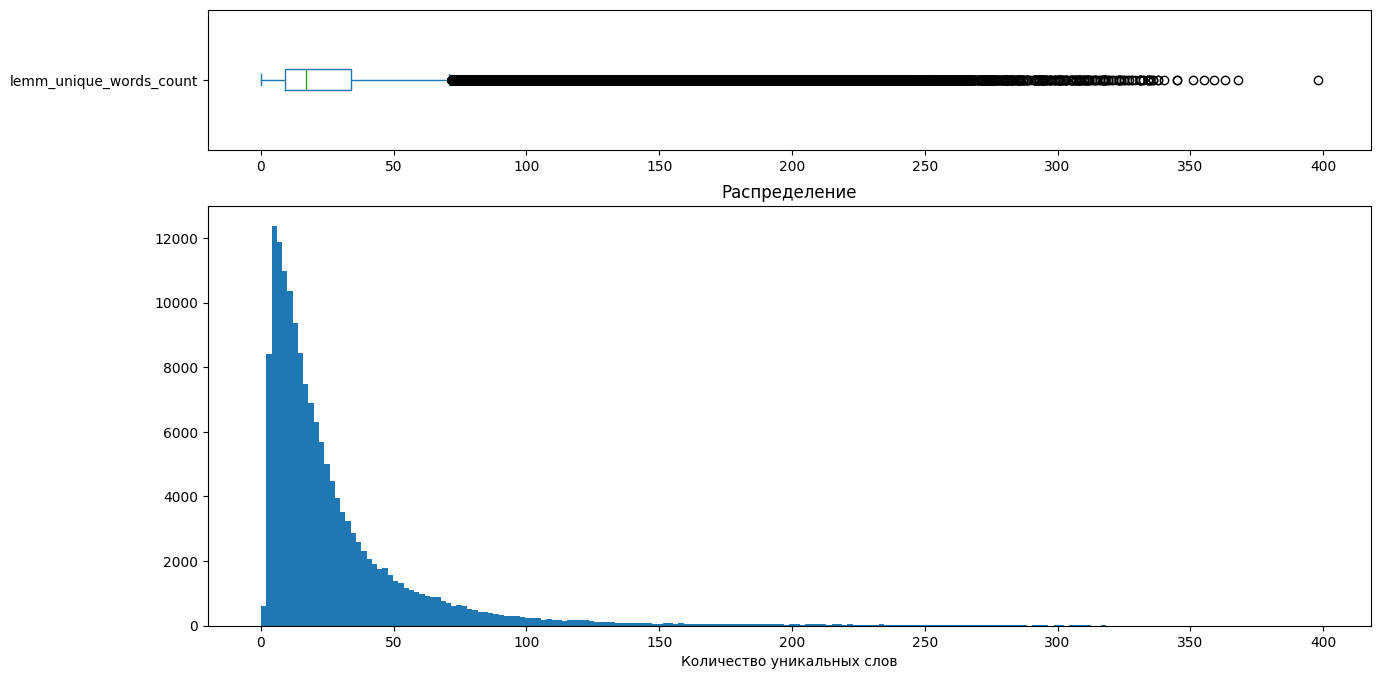

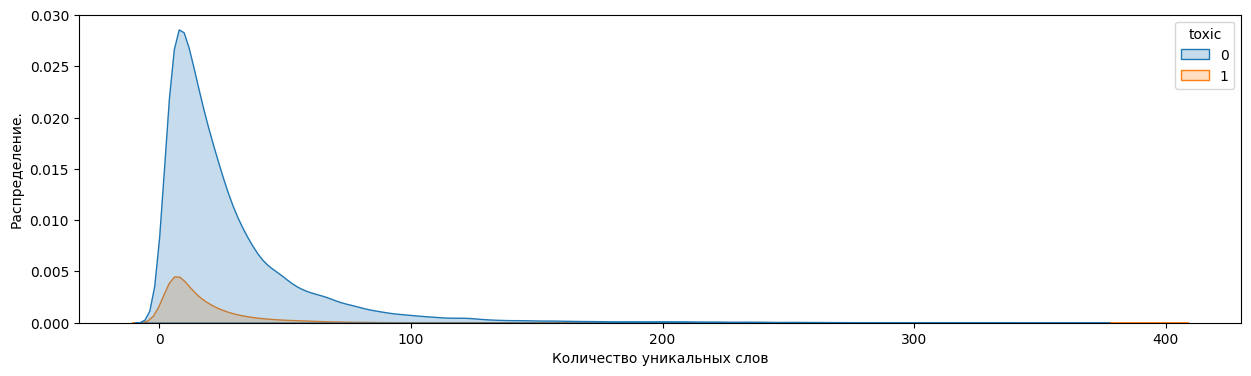

_____________________________________________________________________________________________________________________________
 
 Поле : lemm_words_koeff - lemm_words_koeff 
     Количество пропусков -   24
     Доля пропусков -   0.02 %

count    159268.000000
mean          0.889622
std           0.125550
min           0.000800
25%           0.820513
50%           0.920000
75%           1.000000
max           1.000000
Name: lemm_words_koeff, dtype: float64


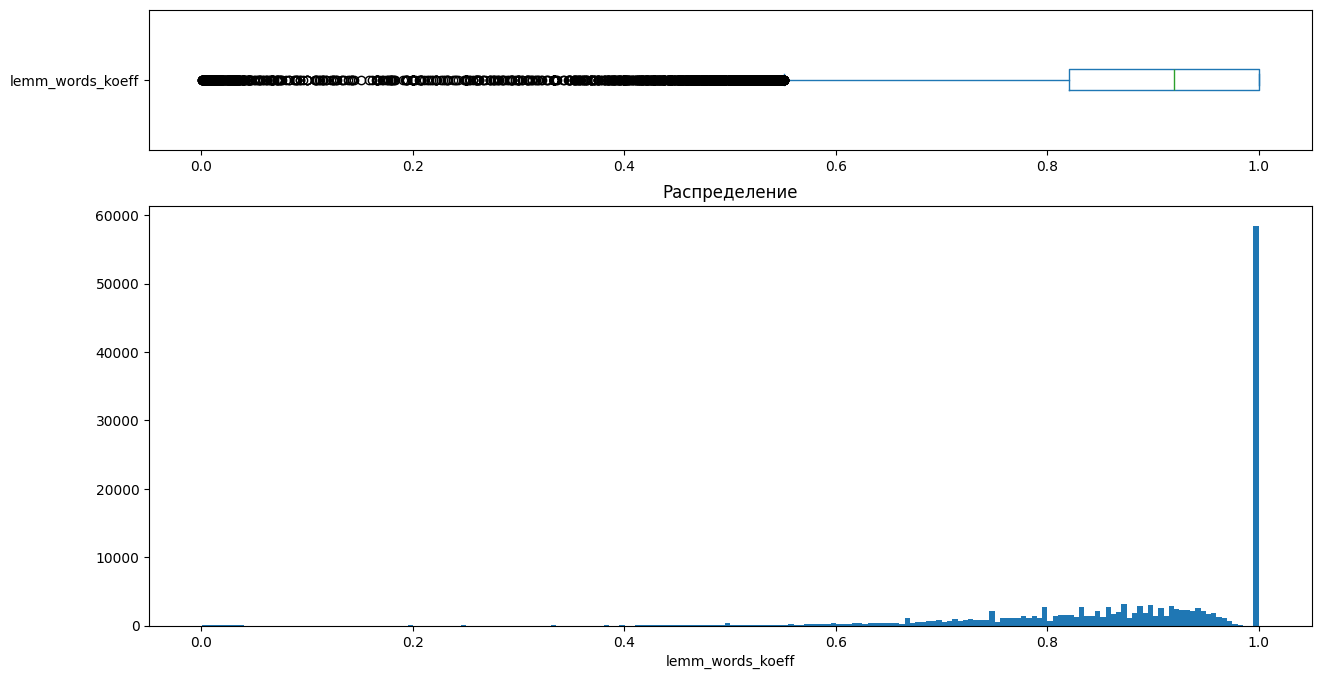

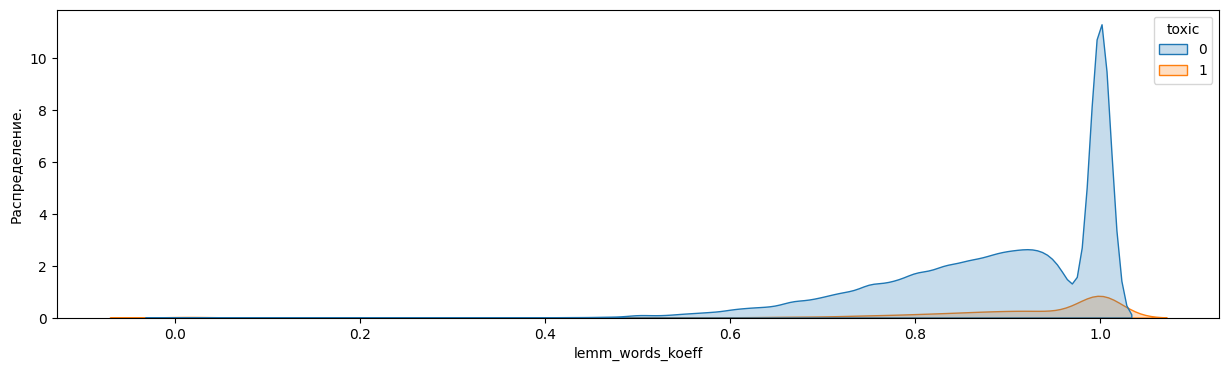

_____________________________________________________________________________________________________________________________
 
 Поле : lemm_comments_len - Длина комментария 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    159292.000000
mean        244.211618
std         381.903210
min           0.000000
25%          57.000000
50%         125.000000
75%         266.000000
max        5000.000000
Name: lemm_comments_len, dtype: float64


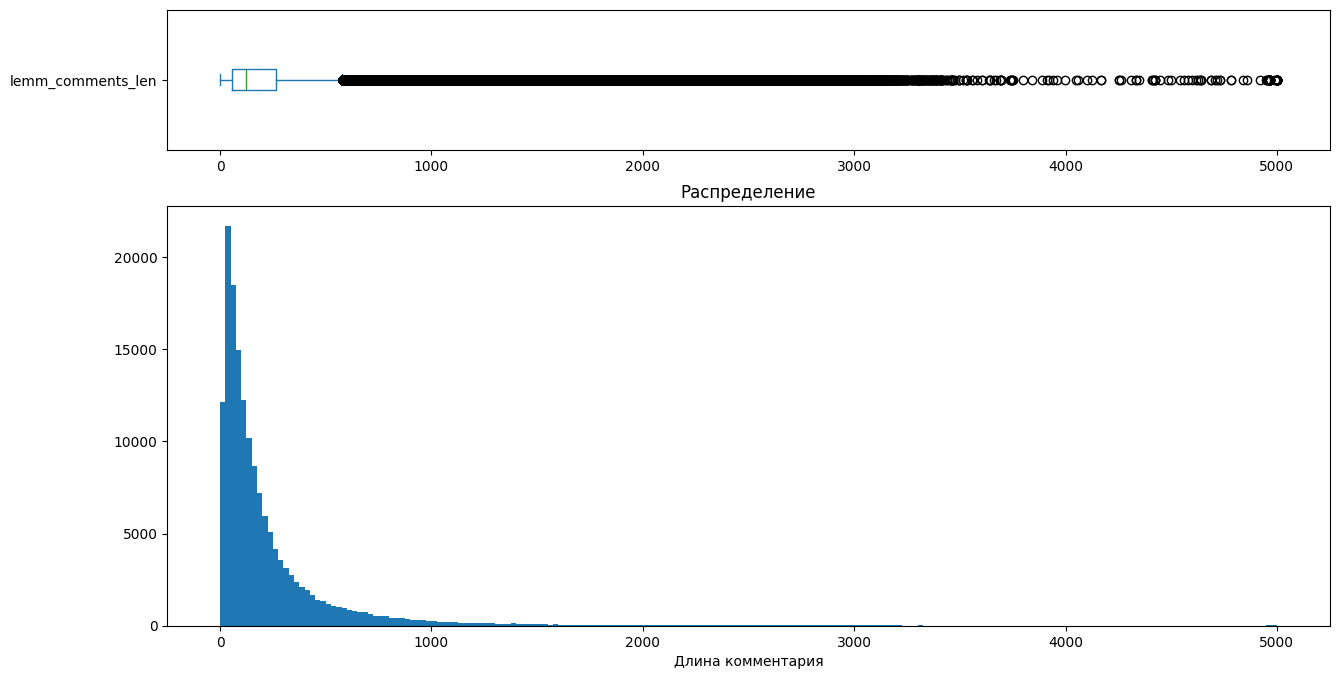

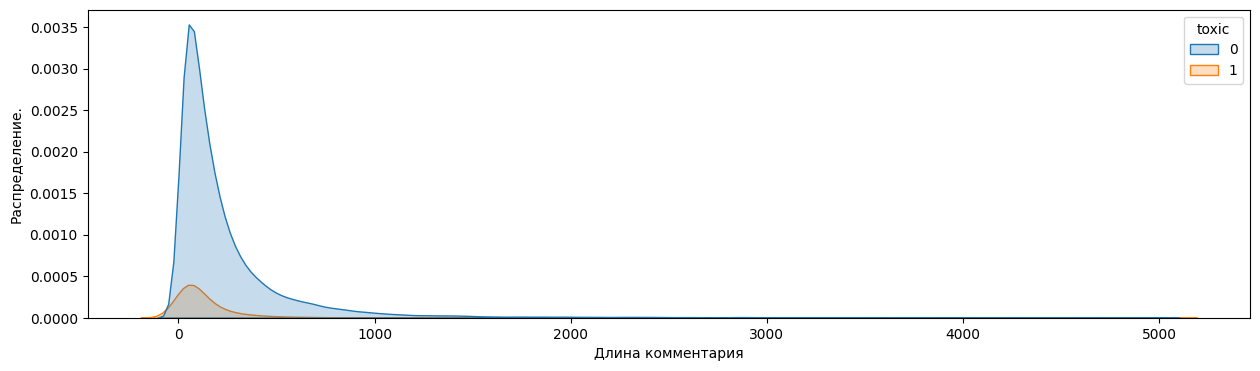

_____________________________________________________________________________________________________________________________
 
 Поле : lemm_letters_count - Колличество букв в лемматизированном комментарии 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    159292.000000
mean        208.296035
std         325.688282
min           0.000000
25%          49.000000
50%         106.000000
75%         227.000000
max        4961.000000
Name: lemm_letters_count, dtype: float64


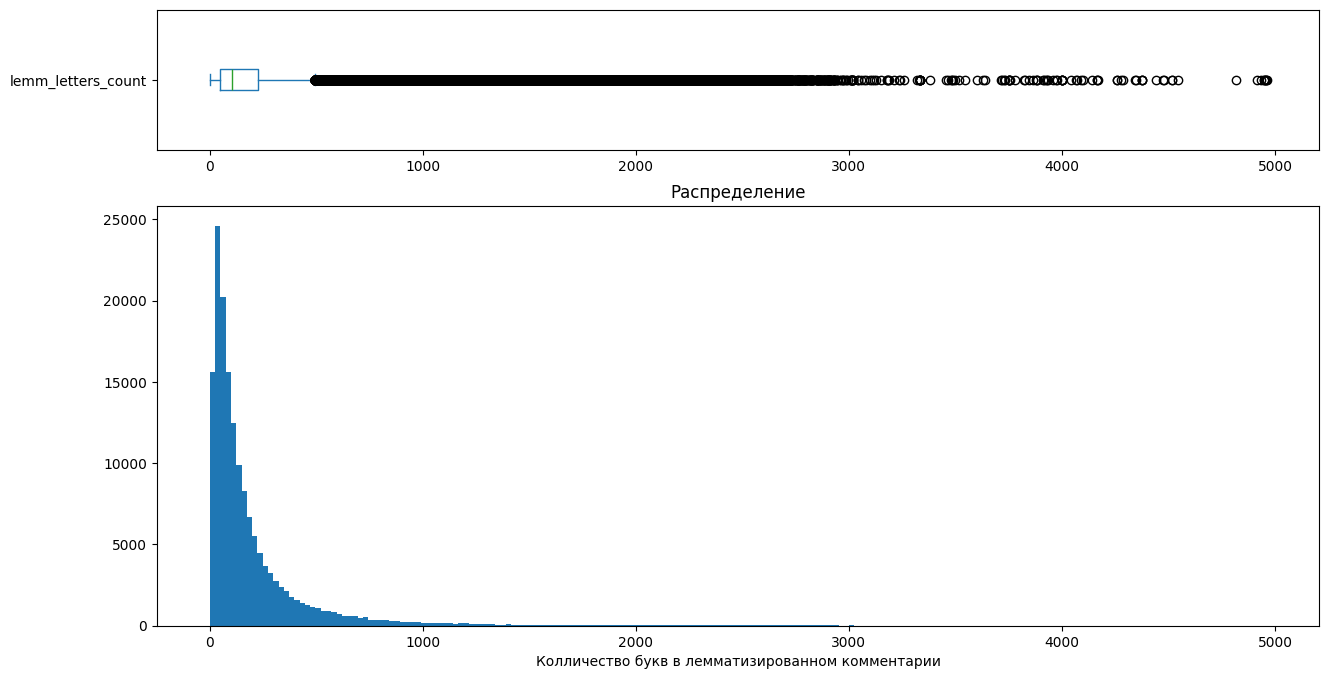

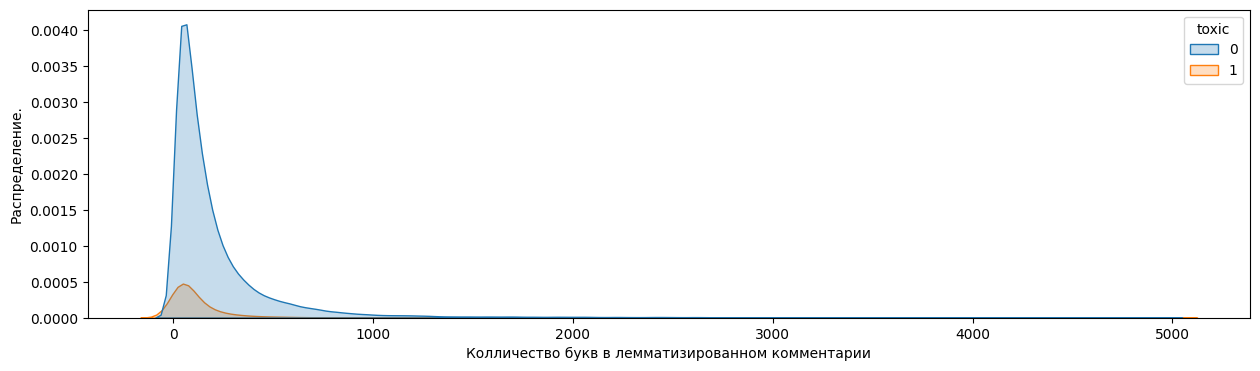

_____________________________________________________________________________________________________________________________
 
 Поле : lemm_words_avg_len - Средняя длина слова 
     Количество пропусков -   24
     Доля пропусков -   0.02 %

count    159268.000000
mean          5.570151
std           6.787275
min           1.000000
25%           5.000000
50%           5.534483
75%           6.000000
max        1389.333333
Name: lemm_words_avg_len, dtype: float64


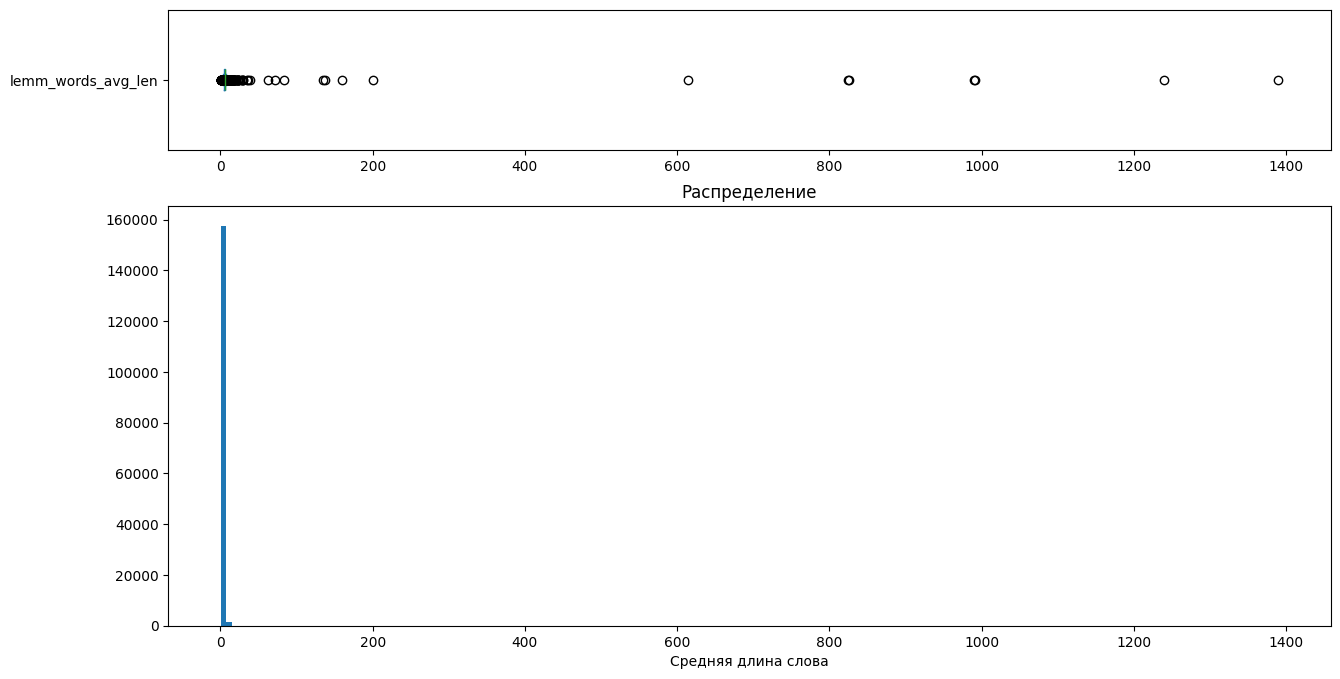

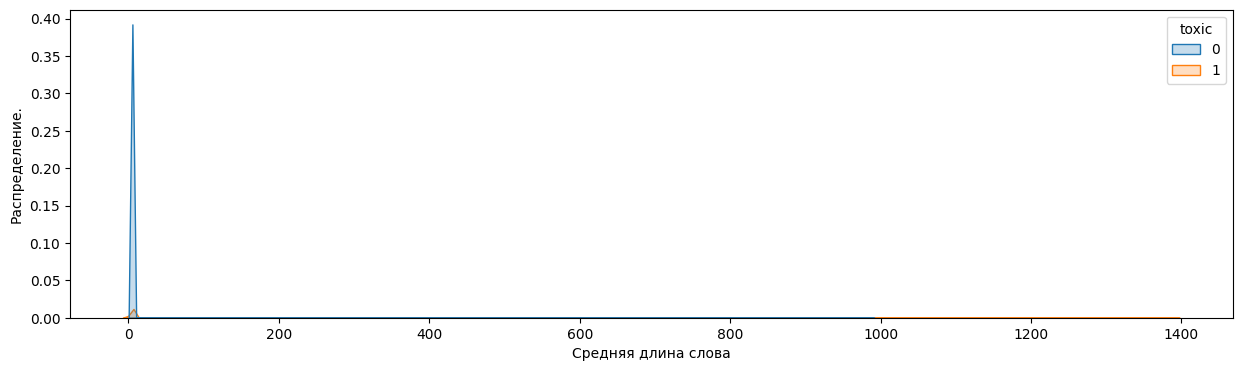

In [26]:
indexes = [
    'lemm_words_count',
    'lemm_unique_words_count',
    'lemm_words_koeff',
    'lemm_comments_len',
    'lemm_letters_count',
    'lemm_words_avg_len'
]
titles = [
    'Количество слов',
    'Количество уникальных слов',
    'lemm_words_koeff',
    'Длина комментария',
    'Колличество букв в лемматизированном комментарии',
    'Средняя длина слова'
]

hue_lst = [
    'toxic'
]

index = 0
for column in indexes:
    column_analiser(
        comments_df,
        column,
        x_label = titles[index],
        y_label = '',
        print_unique = False,
        bins_= 200,
        figsize_ = (15, 8),
        height_ratios_ = [1, 3],
        hue_lst_ = hue_lst, #hue_lst,
        kde_plot_log_flag_ = False,
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = titles[index],
        kde_plot_y_label = 'Распределение.'
)
    index += 1

In [27]:
print(
    blue_start,
    'Количество комментариев, у которых средняя длина слова < 2 - ',
    color_end,
    len(comments_df.query('lemm_words_avg_len > 1 & lemm_words_avg_len < 2'))
     )
display(comments_df.query('lemm_words_avg_len > 1 & lemm_words_avg_len < 2')[
        [
            'toxic',
            'lemm_text',
            'lemm_words_count',
            'lemm_unique_words_count',
            'lemm_comments_len',
            'lemm_words_koeff',
            'lemm_words_avg_len'
        ]
        ])

 Количество комментариев, у которых средняя длина слова < 2 -   31


,toxic,lemm_text,lemm_words_count,lemm_unique_words_count,lemm_comments_len,lemm_words_koeff,lemm_words_avg_len
text_ind,,,,,,,
852,1,p s b tard,4,4,10,1.000000,1.750000
1852,0,t c own t c,5,3,11,0.600000,1.400000
7053,1,moron f u c k f u c k f u c k u c k c r e w k n g r p r c u p n e r g h e z,36,13,75,0.361111,1.111111
14507,1,fuck ff f f f f f f f f,10,3,23,0.300000,1.400000
17878,1,crocker suck n e g r c c k n h e l l,14,10,36,0.714286,1.642857
20895,1,f u c k n g c u n get life sad f u c k n g git,19,10,46,0.526316,1.473684
28473,1,s f ck s f ck go sh t pant,10,7,26,0.700000,1.700000
29686,1,e l l sorry e l l w e e b u r p s,15,9,33,0.600000,1.266667
31860,0,i p aol ip,4,4,10,1.000000,1.750000


In [28]:
print(
    blue_start,
    'Количество комментариев, у которых средняя длина слова = 1 - ',
    color_end,
    len(comments_df.query('lemm_words_avg_len == 1'))
     )

display(comments_df.query('lemm_words_avg_len == 1')[
        [
            'toxic',
            'lemm_text',
            'lemm_words_count',
            'lemm_unique_words_count',
            'lemm_comments_len',
            'lemm_words_koeff',
            'lemm_words_avg_len']
        ])

 Количество комментариев, у которых средняя длина слова = 1 -   6


,toxic,lemm_text,lemm_words_count,lemm_unique_words_count,lemm_comments_len,lemm_words_koeff,lemm_words_avg_len
text_ind,,,,,,,
6053,1,n g g e r f g g,8,5,15,0.625,1.0
34587,1,f u c k u u r e b c h n g g e r,16,10,31,0.625,1.0
53134,1,p e n,3,3,5,1.000,1.0
64257,0,d o,2,2,3,1.000,1.0
67289,1,f u c k u,5,4,9,0.800,1.0
74720,1,p e n,3,3,5,1.000,1.0


In [29]:
print(
    blue_start,
    'Количество комментариев, у которых средняя длина слова > 45 - ',
    color_end,
    len(comments_df.query('lemm_words_avg_len > 45'))
     )


display(comments_df.query('lemm_words_avg_len > 45')[
        [
            'toxic',
            'lemm_text',
            'lemm_words_count',
            'lemm_unique_words_count',
            'lemm_comments_len',
            'lemm_words_koeff',
            'lemm_words_avg_len']
        ])

 Количество комментариев, у которых средняя длина слова > 45 -   14


toxic  \
text_ind          
1869          1   
11786         1   
16232         1   
22633         0   
29554         1   
34607         1   
36065         1   
38614         1   
40809         1   
74697         0   
90224         1   
101286        1   
105646        1   
115507        0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [30]:
# Удаление коментариев в которых количество слов после лемматизации  = 0
comments_df = comments_df.loc[comments_df['lemm_words_count'] > 0]

#### Формирование словарей по очищенному и лемматизированному тексту

In [31]:
# очистка lemm_text, необходимо т.к. появляются стоп слова после лемматизации
comments_df['lemm_text'] = comments_df['lemm_text'].apply(lambda x: clear_text(x, stop_words))

##### Общий словарь

 общий словарь.
___________________________ 
 Количество слов в словаре -   157822


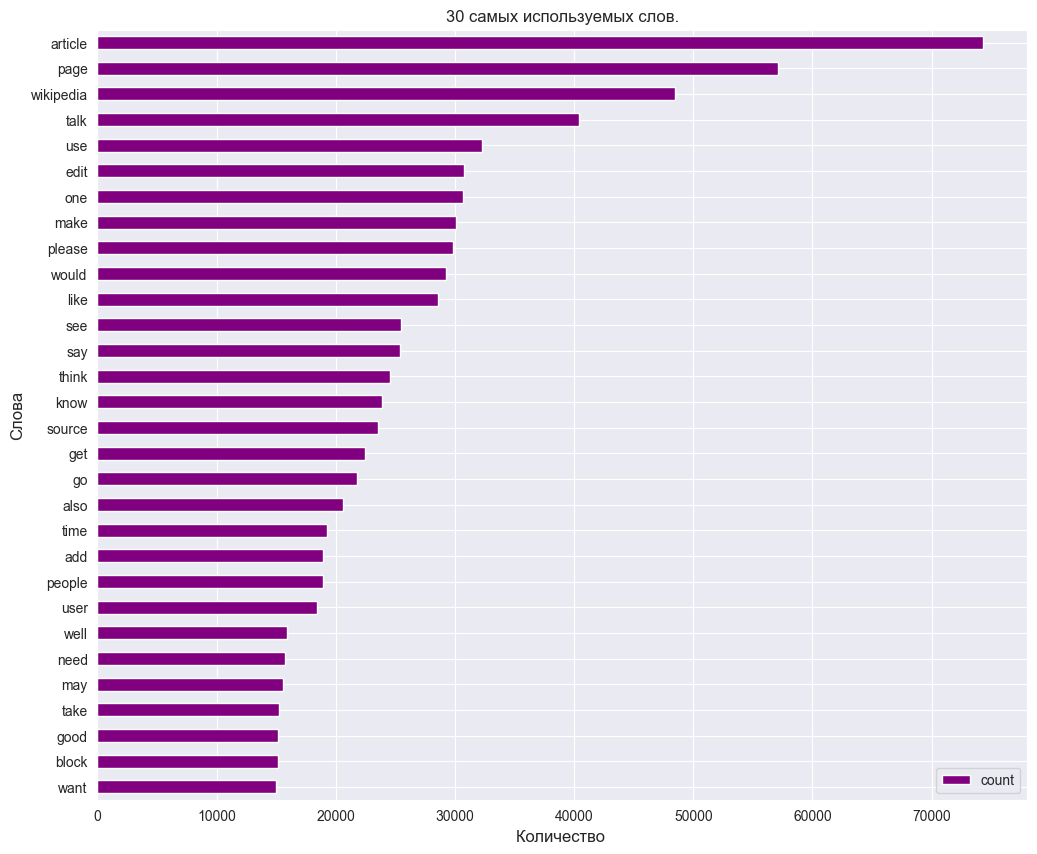

In [32]:
# общий словарь
dictionary_df = get_dictionary(
    comments_df['lemm_text']
)

print(
    blue_start,
    'общий словарь.\n___________________________',
    color_end
)

dictionary_visualization(
    dictionary_df,
    words_count = 30,
    fig_size = (12, 10),
    font_size = 12,
    title_ = '30 самых используемых слов.'
)

##### Токсичный словарь

 Словарь токсичных комментариев.
________________________________________ 
 Количество слов в словаре -   29272


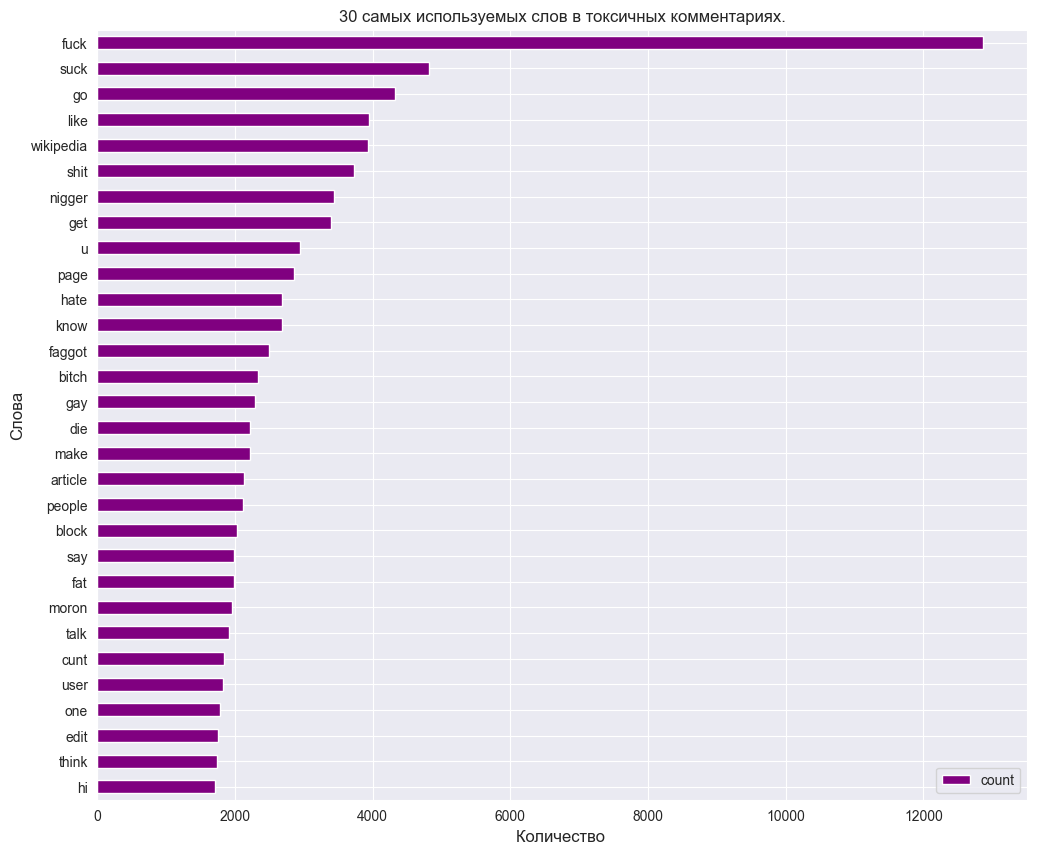

In [33]:
# словарь токсичных комментариев
dictionary_toxic_df = get_dictionary(
    comments_df.query('toxic == 1')['lemm_text']
)

print(
    blue_start,
    'Словарь токсичных комментариев.\n________________________________________',
    color_end
)

dictionary_visualization(
    dictionary_toxic_df,
    words_count = 30,
    fig_size = (12, 10),
    font_size = 12,
    title_ = '30 самых используемых слов в токсичных комментариях.'
)

##### Нетоксичный словарь

 Словарь нетоксичных комментариев.
________________________________________ 
 Количество слов в словаре -   150065


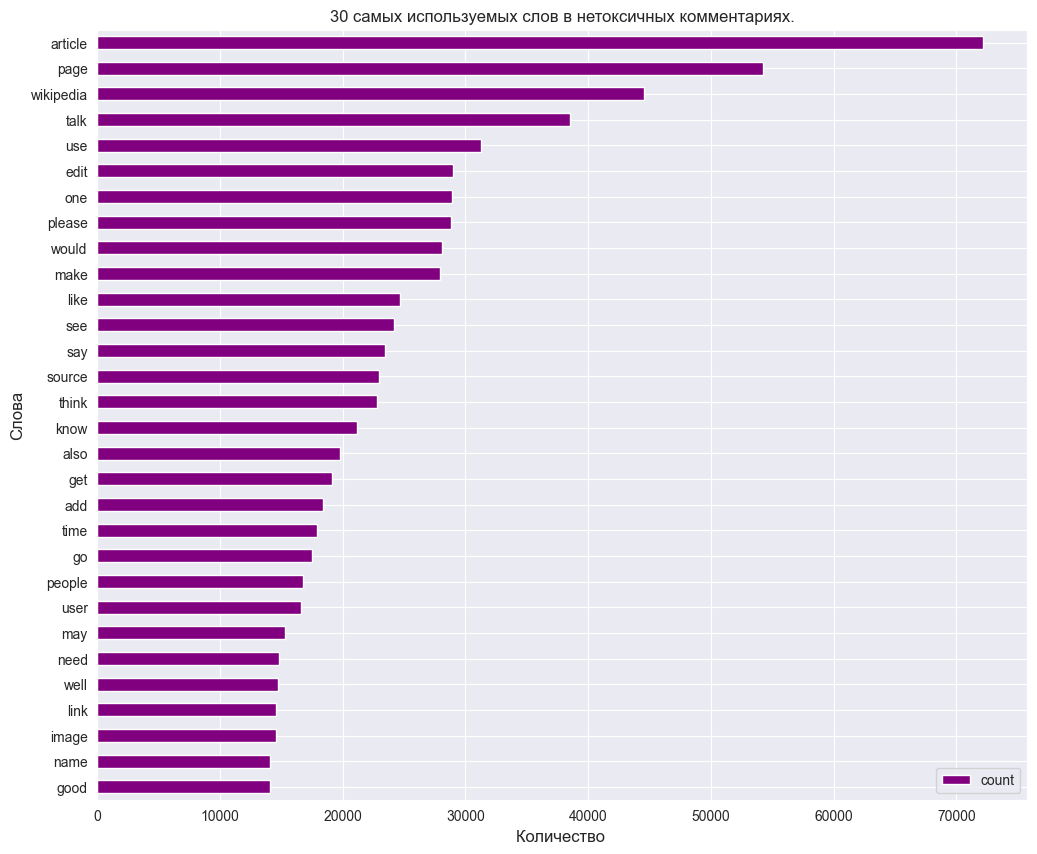

In [34]:
# словарь нетоксичных комментариев
dictionary_no_toxic_df = get_dictionary(
    comments_df.query('toxic == 0')['lemm_text']
)

print(
    blue_start,
    'Словарь нетоксичных комментариев.\n________________________________________',
    color_end
)

dictionary_visualization(
    dictionary_no_toxic_df,
    words_count = 30,
    fig_size = (12, 10),
    font_size = 12,
    title_ = '30 самых используемых слов в нетоксичных комментариях.'
)

#### **`Выводы`**

* Добавлены числовые показатели:

|Показатель|min|max|median|
|:----------|---|---|------|
|**`lemm_words_count`** - количество лемматизированных слов в сообщении|1|1349|20|
|**`lemm_unique_words_count`** - количество уникальных лемматизированных слов в сообщении|1|398|18|
|**`lemm_comments_len`** - длина лемматизированного сообщения|2|5000|126
|**`lemm_letters_count`** - Количество букв в комментарии|2|4961|107|
|**`lemm_words_koeff`** - отношение количества лемматизированных слов к количеству уникальных лемматизированных слов в сообщении|0|1|0.92|
|**`lemm_words_avg_len`** - средняя длина лемматизированного слова в сообщении (без учета пробелов) - количество букв / количество слов|1|1389.3|5.48|
<br>

* Анализ комментариев по числовым показателям выявил:
    * **33 комментария**, у которых средняя длина слова < 2. Эти комментарии, как правило, содержат **1 слово + несколько букв, напечатаных через пробел**.
    * **6 комментариев**, у которых средняя длина слова = 1, т.е **комментарий состоит из букв, напечатанных через пробел**.
    * **14 комментариев**, у которых средняя длина слова > 45 ([максимальная длина разговорного слова английского языка = 45 букв](https://dzen.ru/a/YH7pjKFwkkQUd8gg)). Это комментарии, содержащие многократное повторение букв, или сочетаний букв.
<br>

* Общий словарь комментариев содержит **157717** слов.
    * 5 самых часто используемых слов : **article**, **page**, **wikipedia**, **talk**, **use**
* Словарь токсичных  комментариев содержит **29248** слов.
    * 5 самых часто используемых слов : **fuck**, **suck**, **go**, **like**, **wikipedia**
* Словарь нетоксичных комментариев содержит **149969** слов.
    * 5 самых часто используемых слов : **article**, **page**, **wikipedia**, **talk**, **use**
* TOP 5 cлов всех словарей содержит слово -  **wikipedia** 
* **Общий словарь** и **Словарь нетоксичных комментариев** совпадают.

## Обучение

### Формирование тренировочной и тестовой выборок

In [35]:
# Формирование тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(
    comments_df[['lemm_text']],
    comments_df['toxic'],
    test_size = 0.2,
    stratify = comments_df['toxic'], #.values
    shuffle = True,
    random_state = RANDOM_STATE
)

### Преобразование текста в TF-IDF векторы

In [ ]:
# Преобразование текста в TF-IDF векторы

count_tf_idf = TfidfVectorizer()
X_vectorized_train = count_tf_idf.fit_transform(X_train['lemm_text'])
X_vectorized_test = count_tf_idf.transform(X_test['lemm_text'])

### Определение параметров для поиска лучшей модели

In [ ]:
print(range(15))

In [ ]:
param_dist = [
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', class_weight = 'balanced')],
        'models__penalty': ['l1', 'l2'], 
#        'models__C': [1, 5, 9, 20, 50]
        'models__C': range(1, 15)
    },
    {
        'models': [RandomForestClassifier(class_weight = 'balanced', random_state = RANDOM_STATE)],
        'models__n_estimators': [10, 20, 40],
        'models__max_depth': [1, 10, 20],
    },    
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': [20, 25],
        'models__max_features': [2, 5, 8]
    }
]

In [ ]:
# Основной пайплайн
pipe_final = Pipeline([
    ('models', LogisticRegression(random_state = RANDOM_STATE))
])

In [ ]:
search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_dist,
    n_iter = 100,
    cv = 3,
    verbose = 1,
    scoring = 'f1',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

In [ ]:
%%time
search.fit(X_vectorized_train, y_train)

### Результаты кросс-валидации

In [ ]:
cv_results = pd.DataFrame(search.cv_results_)

# Формирование поля models_name
cv_results['models_name'] = cv_results['param_models'].astype(str)
cv_results['models_name'] = cv_results['models_name'].apply(lambda x: x.split('(', 1)[0])

results = pd.DataFrame(
    cv_results.groupby('models_name').agg({'mean_test_score': 'max', 'mean_fit_time': 'min'})
                      ).reset_index()

# Формирование поля mean_test_score
results['mean_test_score'] = results['mean_test_score'].apply(lambda x: round(abs(x), 2))

display(results.sort_values(by = 'mean_test_score', ascending = False))

In [ ]:
print(blue_start, 'Лучшая модель и её параметры :', color_end, search.best_estimator_, '\n')
print(blue_start, 'Лучшая метрика на кросс валидации :', color_end, round(search.best_score_, 2), '\n')

### **`Выводы`**

* Состав исследуемых алгоритмов:
    * **`LogisticRegression`**
    * **`RandomForestClassifier`**
    * **`DecisionTreeClassifier`**<br>

* Оценка алгоритмов проводилась по значению метрики **`F1`**
* Результаты кросс-валидации:
<br>

|models_name|mean_test_score (F1)|mean_fit_time|
|:----------|--------------------|-------------|
|LogisticRegression|0.76|1.349504|
|RandomForestClassifier|0.38|0.363489|
|DecisionTreeClassifier|0.00|0.097314|
<br>

* Лучшая модель - **`LogisticRegression`**, значение метрики **`F1 - 0.76`**

## Формирование прогнозов по лучшей модели

In [ ]:
# Лучшая модель
best_param_model = search.best_estimator_.fit(X_vectorized_train, y_train)

# Формирование прогнозов на тэсте
predict_lr = best_param_model.predict(X_vectorized_test);

# Расчет метрики F1
f1_score_lr = f1_score(y_test, predict_lr)
print(blue_start, 'Метрика F1 на тестовых данных:', color_end, round(f1_score_lr, 4))

### ConfusionMatrix

In [ ]:
# Формирование confusion_matrix
cm = confusion_matrix(y_test, predict_lr)
cmp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
sns.set_style("whitegrid", {'axes.grid' : False})
cmp.plot();

### **`Выводы`**

* Тестовая выборка состоит из `31854` наблюдений:
    * `28716` - нетоксичных комментариев
    * `3237` - токсичных комментариев
* Значение метрик на тестовой выборке:
    * **F1** =  `0.7538` - среднее гармоническое между precision и recall. F1 достигает максимального значения, когда исходные метрики равны единице.
* Матрица ошибок показывает детальную картину производительности модели (количество правильных и ошибочных прогнозов по каждому классу):
    * **True Negatives (TN)**: `27529` случаев, когда модель **правильно спрогнозировала нетоксичность** - `96.20%`
    * **True Positives (TP)**: `2616` случаев, когда модель **правильно спрогнозировала токсичность** - `80.82%`
    * **False Positives (FP)**: `621` случай, когда модель **неправильно предсказала токсичность** - `19.18%`
    * **False Negatives (FN)**: `1088` случая, когда модель **неправильно предсказала нетоксичность** - `3.8%`
* Резюме по матрице ошибок:
    * Правильных прогнозов - 27529 + 2616 = 30145 - **94.63%**
    * Ошибочных прогнозов - 621 + 1088 = 1709 - **5.37%**
    * Модель лучше прогнозирует **нетоксичность комментариев** - `94.63%` правильных прогнозов. Правильных ответов по прогнозу **токсичности** - `5.37%.`
* **Модель соответствует проектным требованиям. Метрика на тестовой выборке `F1 = 0.7538 > 0.75`**

## Анализ ошибок модели (остатков)

In [ ]:
# Формирование полей: прогноз, факт и остатки
X_test['prediction'] = predict_lr
X_test['fact'] = y_test
X_test['residuals'] = X_test['prediction'] ^ X_test['fact']

In [ ]:
X_test = pd.merge(X_test, comments_df['text'], left_index = True, right_index = True)

In [ ]:
# Объединение прогнозов и оригинального датафрейма
X_test = pd.merge(
    X_test,
    comments_df[[
        'text',
        'lemm_words_count',
        'lemm_unique_words_count',
        'lemm_words_koeff',
        'lemm_comments_len',
        'lemm_letters_count',
        'lemm_words_avg_len'
    ]],
    left_index = True,
    right_index = True
                 )

### Словарь остатков

In [ ]:
# словарь остатков
dictionary_residuals_df = get_dictionary(
    X_test.query('residuals == 1')['lemm_text']
)

# Визуализация словаря остатков
dictionary_visualization(
    dictionary_residuals_df,
    words_count = 30,
    fig_size = (12, 10),
    font_size = 12,
    title_ = '30 самых используемых слов в ошибочных прогнозах.'
)

### Визуализация числовых признаков

In [ ]:
indexes = [
    'lemm_words_count',
    'lemm_unique_words_count',
    'lemm_words_koeff',
    'lemm_comments_len',
    'lemm_letters_count',
    'lemm_words_avg_len'
]
titles = [
    'Количество слов',
    'Количество уникальных слов',
    'lemm_words_koeff',
    'Длина комментария',
    'Колличество букв в лемматизированном комментарии',
    'Средняя длина слова'
]

hue_lst = ['prediction']

index = 0
for column in indexes:
    column_analiser(
        X_test.query('residuals == 1'),
        column,
        x_label = titles[index],
        y_label = '',
        print_unique = False,
        bins_= 200,
        figsize_ = (15, 8),
        height_ratios_ = [1, 3],
        hue_lst_ = hue_lst,
        kde_plot_log_flag_ = False,
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = titles[index],
        kde_plot_y_label = 'Распределение.'
)
    index += 1

### **`Выводы`**

* Характеристики числовых показателей остатков:

|Показатель|min|max|median|
|:----------|---|---|------|
|**`lemm_words_count`** - количество лемматизированных слов в сообщении|1|834|17|
|**`lemm_unique_words_count`** - количество уникальных лемматизированных слов в сообщении|1|334|15|
|**`lemm_comments_len`** - длина лемматизированного сообщения|2|4967|105|
|**`lemm_letters_count`** - Количество букв в комментарии|2|4443|89|
|**`lemm_words_koeff`** - отношение количества лемматизированных слов к количеству уникальных лемматизированных слов в сообщении|0.0023|0.9355|1|
|**`lemm_words_avg_len`** - средняя длина лемматизированного слова в сообщении (без учета пробелов) - количество букв / количество слов|1.6154|16.2809|5.1765|
<br>

* Общий словарь по неправильно классифицируемым комментариям **9177** слов.
    * 5 самых часто используемых слов : **bastered**, **page**, **wikipedia**, **get**, **like**

## **`Выводы`**

* Для построения модели классификации предоставленны данные по 159292 - комментариям:
    * 10.16% токсичные комментарии
    * 89.84% нетоксичные комментарии
    
<br>
* Добавлены числовые показатели:

|Показатель|min|max|median|
|:----------|---|---|------|
|**`lemm_words_count`** - количество лемматизированных слов в сообщении|1|1349|20|
|**`lemm_unique_words_count`** - количество уникальных лемматизированных слов в сообщении|1|398|18|
|**`lemm_comments_len`** - длина лемматизированного сообщения|2|5000|126
|**`lemm_letters_count`** - Количество букв в комментарии|2|4961|107|
|**`lemm_words_koeff`** - отношение количества лемматизированных слов к количеству уникальных лемматизированных слов в сообщении|0|1|0.92|
|**`lemm_words_avg_len`** - средняя длина лемматизированного слова в сообщении (без учета пробелов) - количество букв / количество слов|1|1389.3|5.48|
<br>

* Анализ комментариев по числовым показателям выявил:
    * **33 комментария**, у которых средняя длина слова < 2. Эти комментарии, как правило, содержат **1 слово + несколько букв, напечатаных через пробел**.
    * **6 комментариев**, у которых средняя длина слова = 1, т.е **комментарий состоит из букв, напечатанных через пробел**.
    * **14 комментариев**, у которых средняя длина слова > 45 ([максимальная длина разговорного слова английского языка = 45 букв](https://dzen.ru/a/YH7pjKFwkkQUd8gg)). Это комментарии, содержащие многократное повторение букв, или сочетаний букв.<br>

* Общий словарь комментариев содержит **157717** слов.
    * 5 самых часто используемых слов : **article**, **page**, **wikipedia**, **talk**, **use**
* Словарь токсичных  комментариев содержит **29248** слов.
    * 5 самых часто используемых слов : **fuck**, **suck**, **go**, **like**, **wikipedia**
* Словарь нетоксичных комментариев содержит **149969** слов.
    * 5 самых часто используемых слов : **article**, **page**, **wikipedia**, **talk**, **use**
* Общий словарь по неправильно классифицируемым комментариям **9177** слов.
    * 5 самых часто используемых слов : **bastered**, **page**, **wikipedia**, **get**, **like***
* TOP 5 cлов всех словарей содержит слово -  **wikipedia**
<br>
<br>
* Состав исследуемых алгоритмов для построения модели:
    * **`LogisticRegression`**
    * **`RandomForestClassifier`**
    * **`DecisionTreeClassifier`**<br>

* Лучшая модель - **`LogisticRegression`**, значение метрики на кросс - валидации **`F1 - 0.76`**
<br>

* Матрица ошибок показывает детальную картину производительности модели (количество правильных и ошибочных прогнозов по каждому классу):
    * **True Negatives (TN)**: `27529` случаев, когда модель **правильно спрогнозировала нетоксичность** - `96.20%`
    * **True Positives (TP)**: `2616` случаев, когда модель **правильно спрогнозировала токсичность** - `80.82%`
    * **False Positives (FP)**: `621` случай, когда модель **неправильно предсказала токсичность** - `19.18%`
    * **False Negatives (FN)**: `1088` случая, когда модель **неправильно предсказала нетоксичность** - `3.8%`
* Резюме по матрице ошибок:
    * Правильных прогнозов - 27529 + 2616 = 30145 - **94.63%**
    * Ошибочных прогнозов - 621 + 1088 = 1709 - **5.37%**
    * Модель лучше прогнозирует **нетоксичность комментариев** - `94.63%` правильных прогнозов. Правильных ответов по прогнозу **токсичности** - `5.37%.`
* **Модель соответствует проектным требованиям. Метрика на тестовой выборке `F1 = 0.7538 > 0.75`**